### Loading Library

In [3]:
warning = 1
message = -1

library(doParallel)
library(readr)
library(tidyverse)
library(dplyr)
library(ggplot2)
library(plotly)         
library(scales)      
library(kknn) 
library(caret)
library(ISLR)
library(class)
library(C50)
library(kernlab) 
library(ranger)               
library(e1071)
library(MASS)
library(RColorBrewer)
library(randomForest)
library(corrplot)
library(corrgram)

### Setting up Woking directory

In [54]:

warning = 1

setwd("/Users/sarath/Desktop/mer/S3Output")
LargeMatrix <- read_csv("LargeMatrix.csv")

Parsed with column specification:
cols(
  .default = col_integer()
)
See spec(...) for full column specifications.


In [6]:
galaxy <- read_csv("galaxy_smallmatrix_labeled_8d.csv")


Parsed with column specification:
cols(
  .default = col_integer()
)
See spec(...) for full column specifications.


### Intial Exploration

In [9]:
any(is.na(galaxy))

[1] FALSE

#### Histogram

In [10]:
plot_ly(galaxy, x= ~galaxysentiment, type='histogram')

HTML widgets cannot be represented in plain text (need html)

In [53]:
#correlation####
corr.data <- cor(galaxy)


ERROR: Error in cor(galaxy): 'x' must be numeric


#### Correlation Diagram

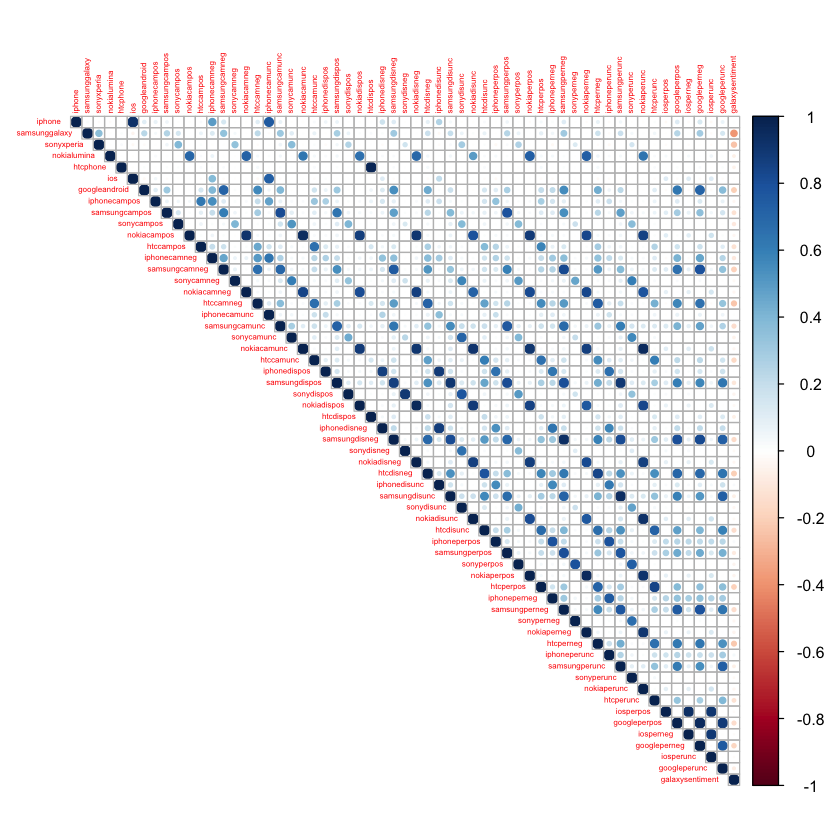

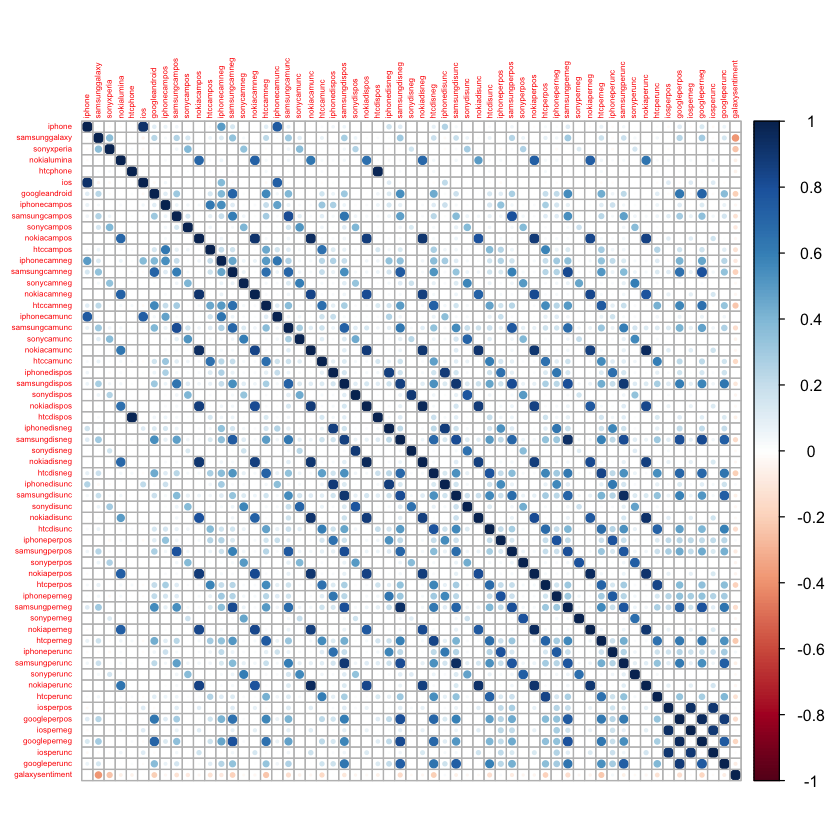

In [12]:
#corr.data
corrplot(corr.data, tl.cex = 0.4, type = "upper")
corrplot (corr.data, tl.cex = 0.4, method = c('circle'), type= 'full')

### Pre process 

In [13]:
# create a new data set and remove features highly correlated with the dependant 
galaxyCOR <- galaxy
galaxyCOR$featureToRemove <- NULL

### Examine Feature Variance

In [55]:

nzv <- nearZeroVar(galaxy, saveMetrics = TRUE)


In [15]:
## nearZeroVar() with saveMetrics = FALSE returns an vector 
nzvF <- nearZeroVar(galaxy, saveMetrics = FALSE) 
nzvF

[1]  3  4  6  7  9 10 11 12 13 14 15 16 17 19 20 21 22 24 25 26 27 29 30 31 32
[26] 34 35 36 37 39 40 41 42 44 45 46 47 49 50 51 52 53 54 55 56 57 58

In [56]:
## create a new data set and remove near zero variance features
galaxyNZV <- galaxy[,-nzvF]


### Recursive Feature Elimination 

In [17]:

# Let's sample the data before using RFE
set.seed(123)
galaxySample <- galaxy[sample(1:nrow(galaxy), 1000, replace=FALSE),]

In [20]:
# Set up rfeControl with randomforest, repeated cross validation and no updates
ctrlgalaxy <- rfeControl(functions = rfFuncs, 
                   method = "repeatedcv",
                   repeats = 5,
                   verbose = FALSE)

In [21]:
# Use rfe and omit the response variable (attribute 59 galaxysentiment) 
rfeResults1 <- rfe(galaxySample[,1:58], 
                   galaxySample$galaxysentiment, 
                  sizes=(1:58), 
                  rfeControl=ctrlgalaxy)
rfeResults1


Recursive feature selection

Outer resampling method: Cross-Validated (10 fold, repeated 5 times) 

Resampling performance over subset size:

 Variables  RMSE Rsquared    MAE RMSESD RsquaredSD   MAESD Selected
         1 1.389   0.3944 1.0542 0.1226     0.1149 0.07862         
         2 1.373   0.4171 1.0809 0.1166     0.1119 0.06780         
         3 1.359   0.4464 1.0898 0.1080     0.1114 0.06305         
         4 1.362   0.4561 1.0971 0.1046     0.1089 0.06054         
         5 1.375   0.4540 1.1130 0.1037     0.1089 0.06354         
         6 1.261   0.4999 0.9298 0.1387     0.1126 0.07716         
         7 1.264   0.4988 0.9389 0.1373     0.1133 0.07488         
         8 1.260   0.5034 0.9389 0.1396     0.1133 0.07872         
         9 1.247   0.5105 0.8906 0.1493     0.1154 0.08272         
        10 1.242   0.5146 0.8872 0.1503     0.1158 0.08226         
        11 1.239   0.5169 0.8873 0.1496     0.1161 0.08112        *
        12 1.243   0.5132 0.8691 0.1541  

In [24]:
saveRDS(rfeResults1, 'rfeResults1.rds') 
rfeResults1_from_file <- readRDS('rfeResults1.rds')

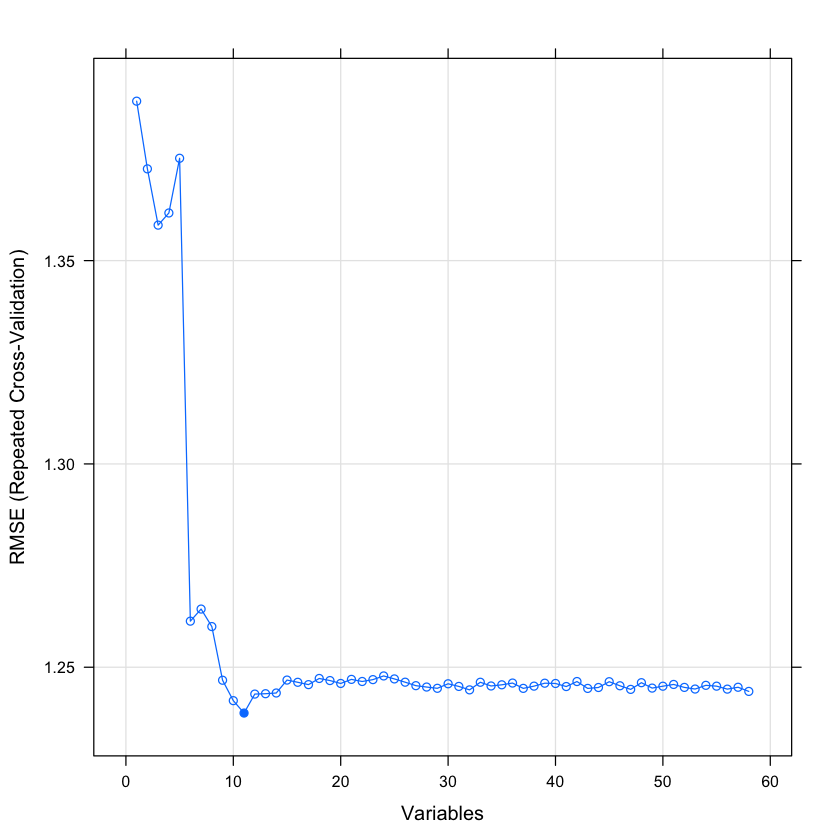

In [25]:
# Plot results
plot(rfeResults1, type=c("g", "o"))

In [52]:
# create new data set with rfe recommended features
galaxyRFE <- galaxy[,predictors(rfeResults1)]



In [51]:
# add the dependent variable to iphoneRFE
galaxyRFE$galaxysentiment <- galaxy$galaxysentiment



### Model Development

In [29]:
#modelling with the iphonefile dataset with C5.0####
galaxy$galaxysentiment<- as.factor(galaxy$galaxysentiment)
intrain3<- caret::createDataPartition(y=galaxy$galaxysentiment,p=0.70,list=FALSE)

trctrl <- caret::trainControl(method = "cv", number = 5)
train3<-galaxy[intrain3,]
test3<-galaxy[-intrain3,]

In [ ]:
warning = FALSE
mc50<- train(galaxysentiment ~., data = train3,
            method = "C5.0",
            trControl=trctrl,
            preProcess = c("center", "scale"))

In [31]:
mc50

C5.0 

9084 samples
  58 predictor
   6 classes: '0', '1', '2', '3', '4', '5' 

Pre-processing: centered (58), scaled (58) 
Resampling: Cross-Validated (5 fold) 
Summary of sample sizes: 7267, 7267, 7268, 7267, 7267 
Resampling results across tuning parameters:

  model  winnow  trials  Accuracy   Kappa    
  rules  FALSE    1      0.7907319  0.5801774
  rules  FALSE   10      0.7782921  0.5613684
  rules  FALSE   20      0.7782921  0.5613684
  rules   TRUE    1      0.7897412  0.5787575
  rules   TRUE   10      0.7803834  0.5637862
  rules   TRUE   20      0.7803834  0.5637862
  tree   FALSE    1      0.7896310  0.5788181
  tree   FALSE   10      0.7796128  0.5634681
  tree   FALSE   20      0.7796128  0.5634681
  tree    TRUE    1      0.7878697  0.5754575
  tree    TRUE   10      0.7754302  0.5538843
  tree    TRUE   20      0.7754302  0.5538843

Accuracy was used to select the optimal model using the largest value.
The final values used for the model were trials = 1, model = rules 

In [47]:
saveRDS(mc50, 'mc50.rds') 
mc50_from_file <- readRDS('mc50.rds')
mc50_Pred <- predict(mc50, newdata = test3)

mc50_CM <-confusionMatrix(mc50_Pred, test3$galaxysentiment)

postResample(mc50_Pred, test3$galaxysentiment)

Accuracy     Kappa 
0.7788635 0.5527869

In [34]:
#modelling with the iphonefile dataset with KKNN####
kknn <- train(galaxysentiment ~., data = train3,
            method = "kknn",
            trControl=trctrl,
            preProcess = c("center", "scale"))

kknn


k-Nearest Neighbors 

9084 samples
  58 predictor
   6 classes: '0', '1', '2', '3', '4', '5' 

Pre-processing: centered (58), scaled (58) 
Resampling: Cross-Validated (5 fold) 
Summary of sample sizes: 7266, 7266, 7268, 7268, 7268 
Resampling results across tuning parameters:

  kmax  Accuracy   Kappa    
  5     0.3018498  0.1532010
  7     0.3186933  0.1632052
  9     0.3267287  0.1663818

Tuning parameter 'distance' was held constant at a value of 2
Tuning
 parameter 'kernel' was held constant at a value of optimal
Accuracy was used to select the optimal model using the largest value.
The final values used for the model were kmax = 9, distance = 2 and kernel
 = optimal.

In [48]:
saveRDS(kknn, 'kknn.rds') 
kknn_from_file <- readRDS('kknn.rds')
kknn_Pred <- predict(kknn, newdata = test3)

kknn_CM <-confusionMatrix(kknn_Pred, test3$galaxysentiment)

postResample(kknn_Pred, test3$galaxysentiment)



Accuracy     Kappa 
0.3232193 0.1656705

In [36]:
#modelling with the iphonefile dataset with svmLinear####

svm<- train(galaxysentiment ~., data = train3,
            method = "svmLinear",
            trControl=trctrl,
            preProcess = c("center", "scale"))
svm

Support Vector Machines with Linear Kernel 

9084 samples
  58 predictor
   6 classes: '0', '1', '2', '3', '4', '5' 

Pre-processing: centered (58), scaled (58) 
Resampling: Cross-Validated (5 fold) 
Summary of sample sizes: 7267, 7267, 7267, 7267, 7268 
Resampling results:

  Accuracy   Kappa    
  0.7352495  0.4471175

Tuning parameter 'C' was held constant at a value of 1

In [49]:
saveRDS(svm, 'svm.rds') 
svm_from_file <- readRDS('svm.rds')
svm_Pred <- predict(svm, newdata = test3)

svm_CM <-confusionMatrix(svm_Pred, test3$galaxysentiment)

postResample(svm_Pred, test3$galaxysentiment)

Accuracy     Kappa 
0.7426074 0.4629811

In [38]:
####modelling with the iphonefile dataset with svmLinear####
rf <- caret::train(galaxysentiment ~., data = train3,
                    method = "rf",
                    trControl=trctrl,
                    preProcess = c("center", "scale"))
rf

Random Forest 

9084 samples
  58 predictor
   6 classes: '0', '1', '2', '3', '4', '5' 

Pre-processing: centered (58), scaled (58) 
Resampling: Cross-Validated (5 fold) 
Summary of sample sizes: 7265, 7267, 7269, 7268, 7267 
Resampling results across tuning parameters:

  mtry  Accuracy   Kappa    
   2    0.7182978  0.3880257
  30    0.7921604  0.5877905
  58    0.7841228  0.5761149

Accuracy was used to select the optimal model using the largest value.
The final value used for the model was mtry = 30.

In [50]:
saveRDS(rf, 'rf.rds') 
rf_from_file <- readRDS('rf.rds')
rf_Pred <- predict(rf, newdata = test3)

rf_CM <-confusionMatrix(rf_Pred, test3$galaxysentiment)

postResample(rf_Pred, test3$galaxysentiment)

Accuracy     Kappa 
0.7950630 0.5953347

### Comparison of Models


Call:
summary.resamples(object = resultsgalaxy)

Models: kNN, RF, svm, C5.0 
Number of resamples: 5 

Accuracy 
          Min.   1st Qu.    Median      Mean   3rd Qu.      Max. NA's
kNN  0.3188326 0.3250825 0.3267327 0.3267287 0.3287445 0.3342511    0
RF   0.7796143 0.7905443 0.7930655 0.7921604 0.7985691 0.7990088    0
svm  0.7303247 0.7314254 0.7358283 0.7352495 0.7369290 0.7417401    0
C5.0 0.7705008 0.7743533 0.7791850 0.7791722 0.7815080 0.7903137    0

Kappa 
          Min.   1st Qu.    Median      Mean   3rd Qu.      Max. NA's
kNN  0.1572340 0.1628807 0.1650943 0.1663818 0.1663859 0.1803139    0
RF   0.5607693 0.5854641 0.5885377 0.5877905 0.6005303 0.6036509    0
svm  0.4362474 0.4364033 0.4463341 0.4471175 0.4527153 0.4638873    0
C5.0 0.5464366 0.5554538 0.5613170 0.5644087 0.5681641 0.5906721    0


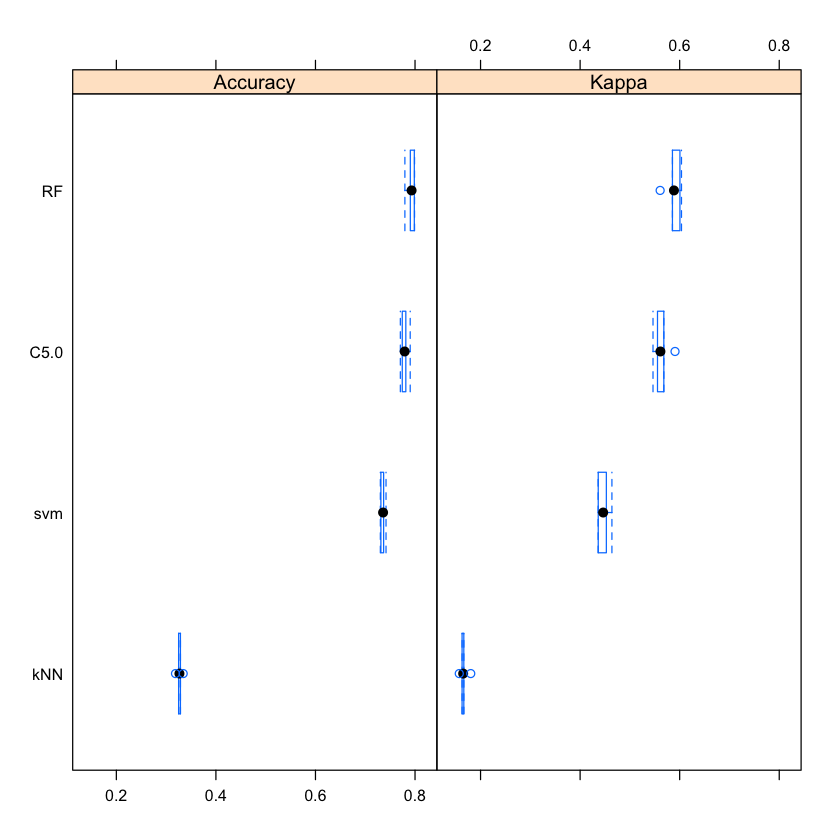

In [40]:
##summary results classificateion
#igalaxy
resultsgalaxy <- resamples(list(kNN=kknn,
                          RF=rf,
                          svm= svm,
                          C5.0=mc50))
summary(resultsgalaxy)

bwplot(resultsgalaxy)

### Apply Model to Data

0    1    2    3    4    5 
9727    1 1335   73   26 6663

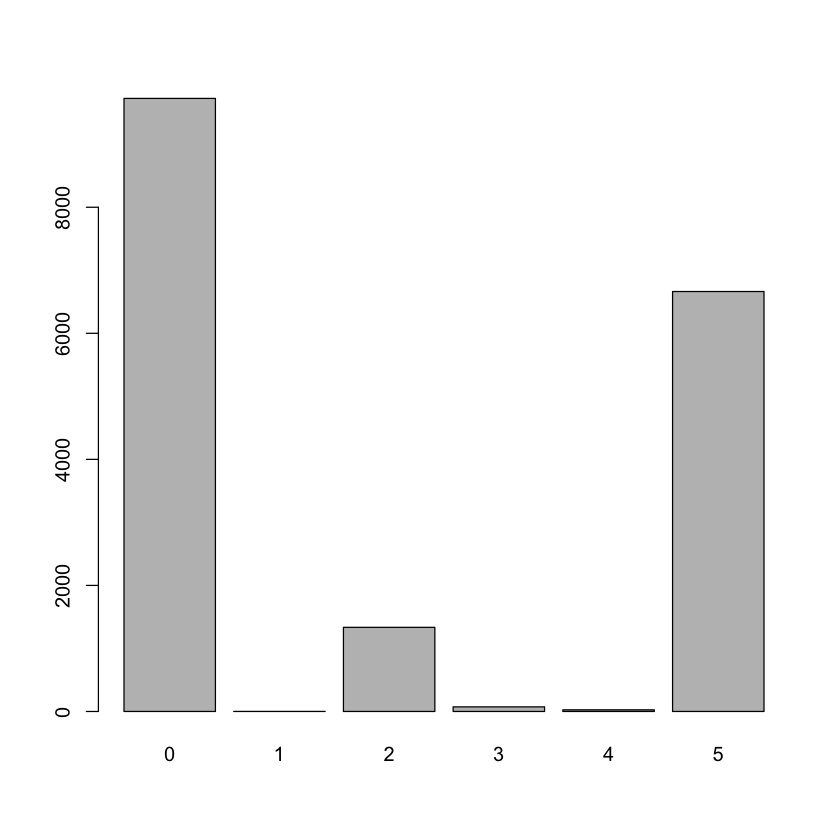

In [41]:
#opening large matrix####
galaxysentimentpred<- predict(rf,newdata = LargeMatrix)
LargeMatrix$galaxysentiment<- galaxysentimentpred
summary(galaxysentimentpred)
plot(galaxysentimentpred)

0    1    2    3    4    5 
7822  181  549 1504  493 7276

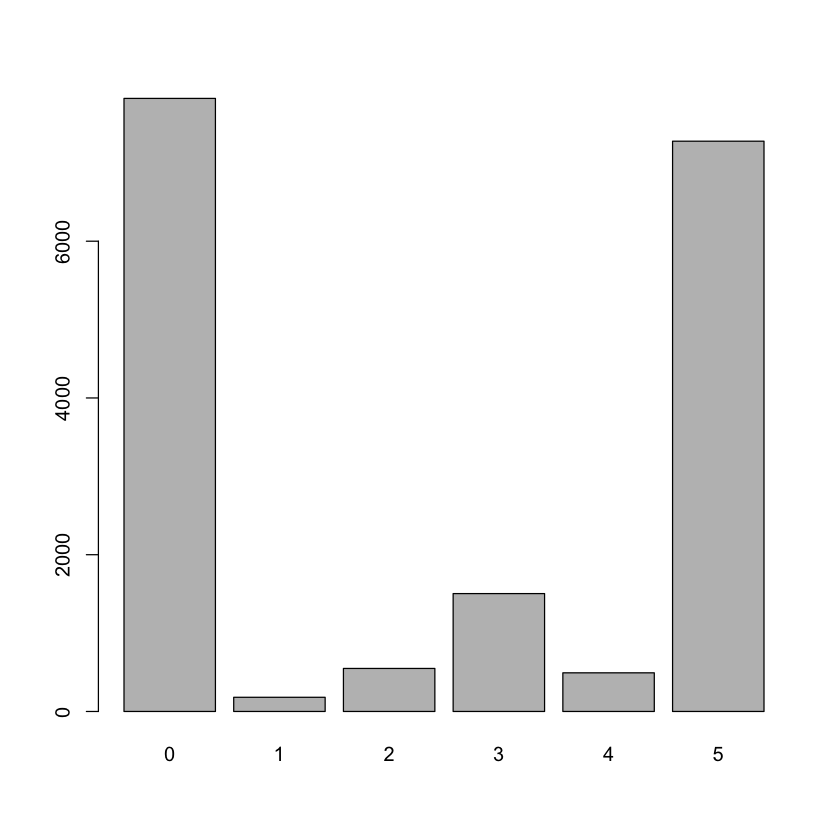

In [42]:
galaxysentimentpred1<- predict(svm,newdata = LargeMatrix)
LargeMatrix$galaxysentiment<- galaxysentimentpred1
summary(galaxysentimentpred1)
plot(galaxysentimentpred1)




In [43]:
write.csv(LargeMatrix, file = "new predicted samsung sentiment.csv")